In [1]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-06 11:43:47.968688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

In [3]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"][:,:-1], norm="l2"
)


/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


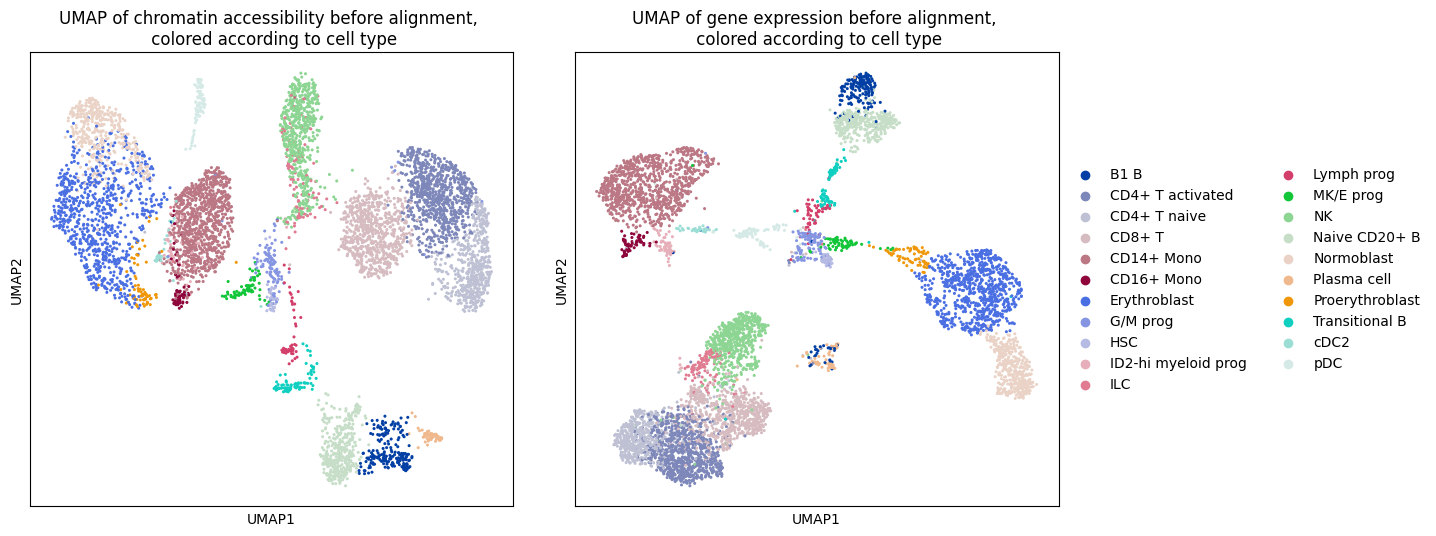

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [5]:
adata_atac_full = adata_atac.copy()
adata_rna_full = adata_rna.copy()

In [6]:
adata_rna = adata_rna_full[~adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])].copy()

In [7]:
adata_atac

AnnData object with n_obs × n_vars = 6224 × 8000
    obs: 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'cell_type', 'batch'
    uns: 'cell_type_colors', 'neighbors'
    obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'X_umap', 'geneactivity_scvi', 'ATAC_lsi_l2_norm'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_rna

AnnData object with n_obs × n_vars = 4975 × 2000
    obs: 'GEX_n_counts', 'GEX_n_genes', 'cell_type', 'batch'
    uns: 'cell_type_colors', 'neighbors'
    obsm: 'GEX_X_pca', 'X_umap', 'geneactivity_scvi'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
source = adata_atac.obsm["ATAC_lsi_l2_norm"]
target = adata_rna.obsm["GEX_X_pca"]

In [10]:
source_red = sc.pp.pca(source, n_comps=10)
target_red = sc.pp.pca(target, n_comps=10)

In [11]:
neural_net = MLP_vector_field(10, 128)
bridge_net = MLP_bridge(10, 10)

mlp_eta = MLP_marginal(128)
mlp_xi = MLP_marginal(128)

linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=1e-3, linear_ot_solver=linear_ot_solver)

graph_kwargs = {"k_neighbors": 801}

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=0.98, tau_b=0.98, cost_fn="graph", input_dim=10, output_dim=10, iterations=5_000, ot_solver=solver, k_noise_per_x=1, graph_kwargs=graph_kwargs, scale_cost="mean")

2023-09-06 11:45:33.639776: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [12]:
otfm(source_red, target_red, 1024, 1024)

100%|██████████| 5000/5000 [17:45<00:00,  4.69it/s]


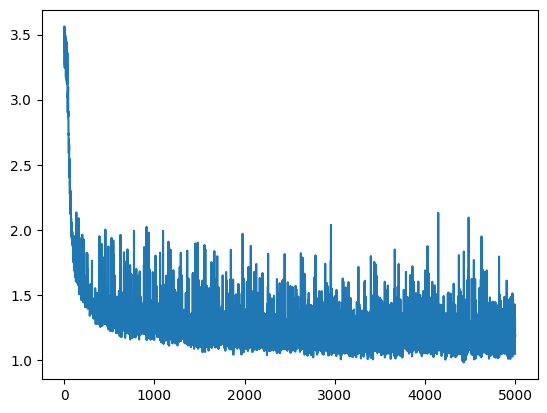

In [13]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [14]:
gex_predicted,_,_ = otfm.transport(source_red, seed=0)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, bu

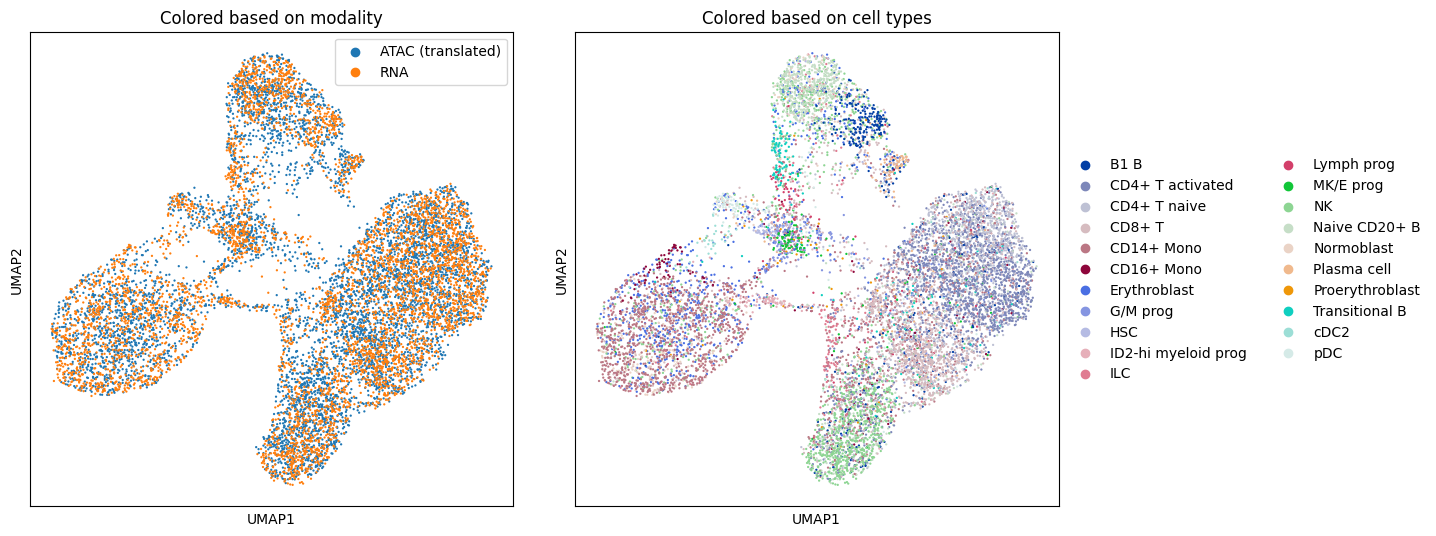

In [15]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[0,...], target_red), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


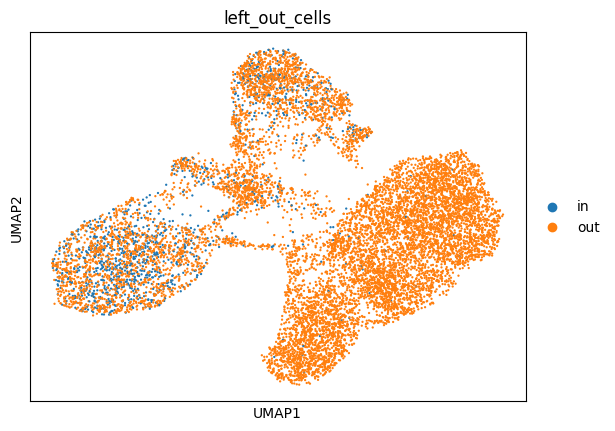

In [35]:
adata.obs["left_out_cells"] = adata.obs.apply(lambda x: "in" if x["cell_type"] in ["Proerythroblast", "Normoblast", "Erythroblast"] else "out", axis=1)
sc.pl.umap(adata, color=["left_out_cells"])

In [16]:
import scipy
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [26]:
source_red_selected = source_red[~adata_atac.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])]
pushed, _, _ = otfm.transport(source_red_selected, seed=0)

In [27]:
pushed.shape

(1, 4975, 10)

In [28]:
import scipy 
foscttm(pushed[0,...], target_red)

0.5283

In [29]:
left_marginals = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=source_red)

In [30]:
adata_atac.obs["learnt_marginals"] = left_marginals
adata_atac.obs.groupby("cell_type").mean("learnt_marginals").sort_values("learnt_marginals")

,ATAC_nCount_peaks,ATAC_nucleosome_signal,learnt_marginals
cell_type,,,
pDC,11577.760870,0.906545,0.763456
cDC2,11196.361111,0.798745,0.769077
Transitional B,10197.481928,0.804502,0.781144
MK/E prog,12329.187500,0.915590,0.782750
G/M prog,12946.972727,0.922695,0.793114
Lymph prog,12115.076923,0.945477,0.800245
CD16+ Mono,6995.484848,0.796882,0.801390
Proerythroblast,11983.492308,0.950453,0.803654
Plasma cell,13720.983051,0.782359,0.809399


In [31]:
right_marginals = otfm.state_eta.apply_fn({"params": otfm.state_xi.params}, x=target_red)

In [32]:
adata_rna.obs["learnt_marginals"] = right_marginals
adata_rna.obs.groupby("cell_type").mean("learnt_marginals").sort_values("learnt_marginals")

,GEX_n_counts,GEX_n_genes,learnt_marginals
cell_type,,,
CD16+ Mono,2719.363525,1578.818182,0.774412
cDC2,5576.861328,2654.194444,0.782428
HSC,4162.829102,2130.195122,0.788133
Transitional B,3935.204834,1935.602410,0.803424
ILC,1064.794067,745.843137,0.804965
G/M prog,6144.600098,2865.472727,0.806377
NK,2198.983154,1366.162437,0.812234
CD14+ Mono,2557.926270,1498.969598,0.813663
ID2-hi myeloid prog,882.104492,619.791045,0.813909


In [23]:
target_red.shape

(6224, 10)

In [24]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_red, seed=i)[0][0,...]

In [25]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [26]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

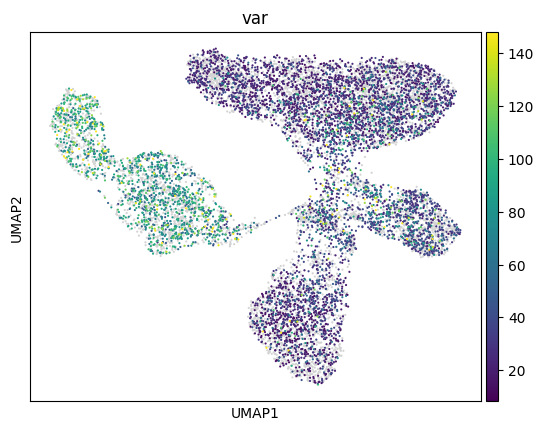

In [27]:
sc.pl.umap(adata, color="var", vmax="p99")

In [20]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,103.850719
CD4+ T activated,102.388118
CD4+ T naive,102.576678
CD8+ T,104.337489
CD14+ Mono,102.705503
CD16+ Mono,97.921965
Erythroblast,103.760177
G/M prog,103.368726
HSC,106.174805


In [32]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,83.601758
CD4+ T activated,19.568209
CD4+ T naive,19.001598
CD8+ T,77.620642
CD14+ Mono,11.951774
CD16+ Mono,12.951762
Erythroblast,131.598336
G/M prog,28.517488
HSC,22.957683


In [33]:
sc.tl.dendrogram(adata, groupby="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


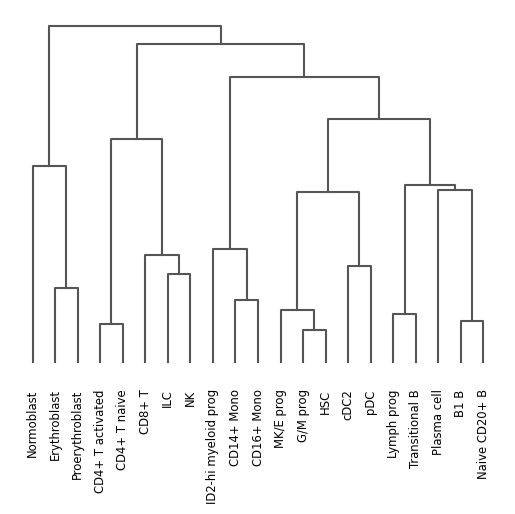

<Axes: >

In [35]:
sc.pl.dendrogram(adata, groupby="cell_type")

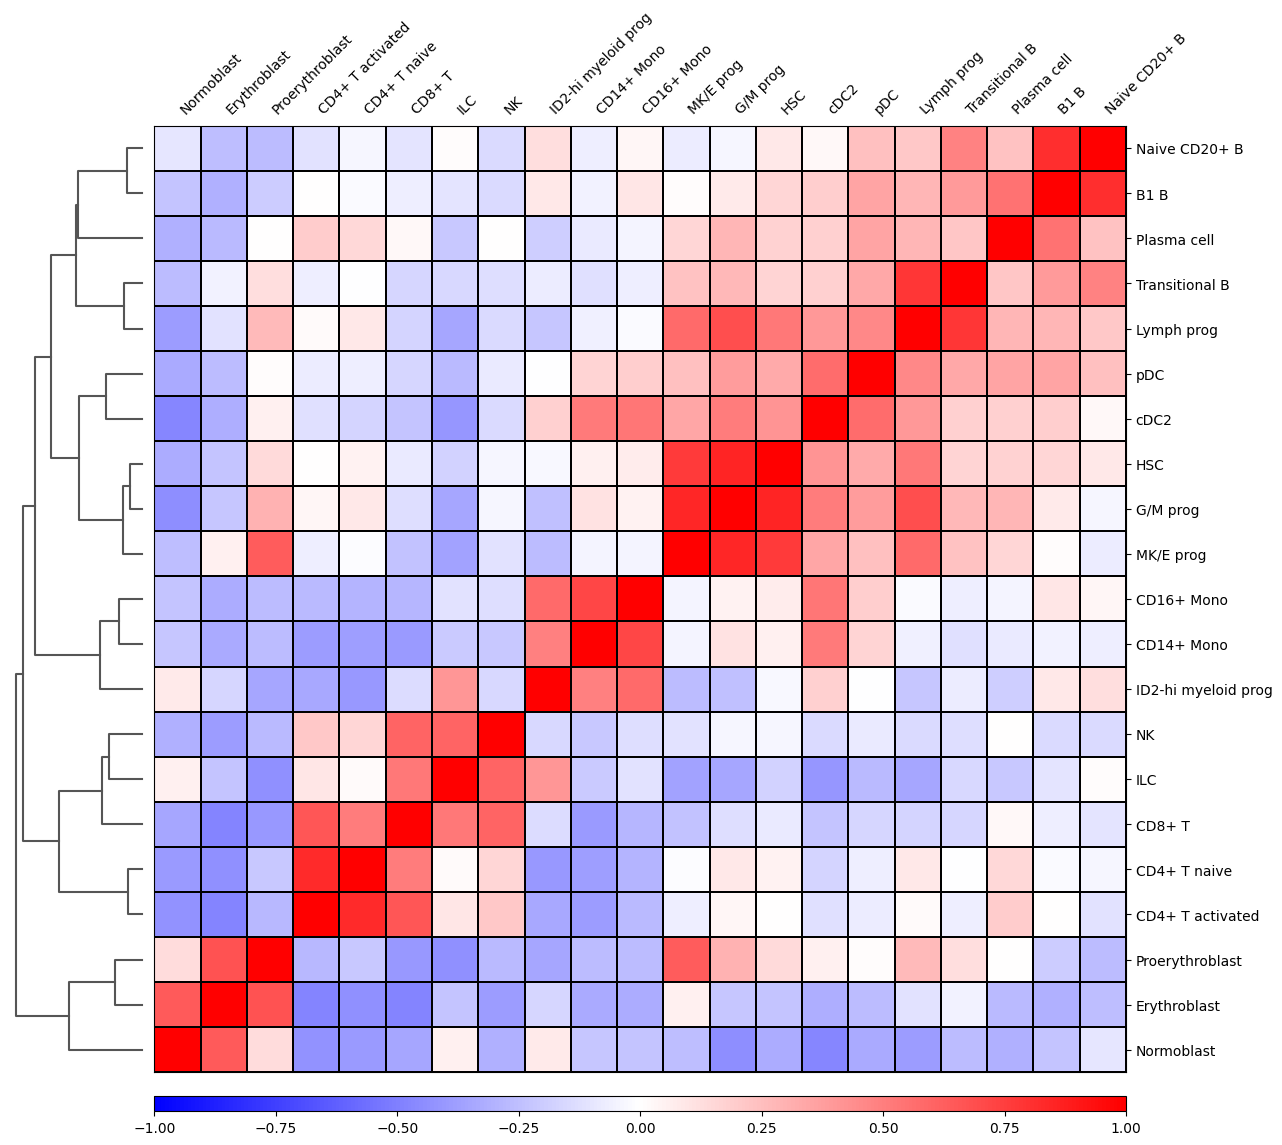

In [37]:
sc.pl.correlation_matrix(adata, groupby="cell_type")